In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
from pathlib import Path

# Add project root to path
proj_root = Path.cwd().parent.parent
sys.path.insert(0, str(proj_root))

from dynamat.mechanical.shpb import PulseDetector, PulseAligner, StressStrainCalculator, TukeyWindow

In [2]:
# Import csv data from test file
raw_df = pd.read_csv("A356_004.txt", sep="\t", header=1)                                        # DYN: This is user input in GUI
raw_df.rename(columns={"(ms)": "time", "(V)":"incident", "(V).1":"transmitted"}, inplace=True)
raw_df.head()

,time,incident,transmitted
0,-0.400024,-0.004883,0.001221
1,-0.400012,-0.004883,0.001221
2,-0.399999,-0.004883,0.001221
3,-0.399987,-0.004883,0.001221
4,-0.399974,-0.004883,0.001221


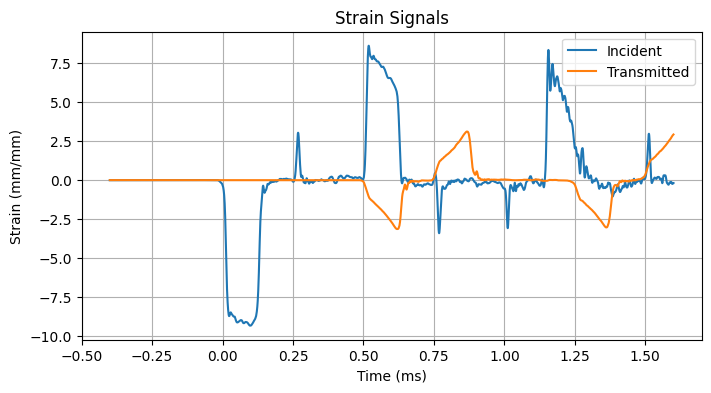

In [3]:
plt.figure(figsize=(8,4))
plt.plot(raw_df["time"], raw_df["incident"], label = "Incident")
plt.plot(raw_df["time"], raw_df["transmitted"], label = "Transmitted")
plt.title(f"Strain Signals")
plt.xlabel("Time (ms)")
plt.ylabel("Strain (mm/mm)")
plt.legend()
plt.grid()
plt.show()

In [4]:
# Calculate pulse duration in data points
# Assuming 0.185 ms pulse duration for 18-inch striker
pulse_duration_ms = 0.185                                                  # DYN: This is determined from striker size using duration (ms) = 2L / C_bar
dt = np.median(np.diff(raw_df["time"]))  # sampling interval in ms
pulse_pts = int(pulse_duration_ms / dt)

print(f"Pulse duration: {pulse_duration_ms} ms")
print(f"Sampling interval: {dt:.6f} ms")
print(f"Pulse points: {pulse_pts}")

# Create detector with configuration
detector = PulseDetector(
    pulse_points=pulse_pts,
    k_trials=(5000, 2000, 1000),  # Try multiple thresholds               # DYN: GUI should allow k_trials if needed
    polarity="compressive",
    min_separation=int(0.8 * pulse_pts)
)

print(f"\nPulseDetector initialized:")
print(f"  Template polarity: {detector.polarity}")
print(f"  Min separation: {detector.min_separation} samples")

Pulse duration: 0.185 ms
Sampling interval: 0.000012 ms
Pulse points: 14800

PulseDetector initialized:
  Template polarity: compressive
  Min separation: 11840 samples


In [5]:
# Create detector with configuration
detector = PulseDetector(pulse_points=pulse_pts,
    k_trials=(5000, 2000, 1000),  # Try multiple thresholds
    polarity="compressive",
    min_separation=int(0.8 * pulse_pts))
print(f"\nPulseDetector initialized:")
print(f"  Template polarity: {detector.polarity}")
print(f"  Min separation: {detector.min_separation} samples")

# Define search bounds to ignore noise regions
# These bounds should be adjusted based on your experimental setup
LB = 10000   # lower bound - start searching after this index                               # DYN: GUI should allow setting UB and LB if needed
UB = 115000  # upper bound - stop searching before this index

# Detect incident pulse
print("Detecting incident pulse...")
incident_window = detector.find_window(
    raw_df["incident"].values,
    lower_bound=LB,
    upper_bound=50000,  # Incident comes first
    metric="median",
    debug=True
)
print(f"Incident window: {incident_window}")


PulseDetector initialized:
  Template polarity: compressive
  Min separation: 11840 samples
Detecting incident pulse...

[find_window] k_sigma = 5000
[matched] σ=1.15e-01 thr=5.73e+02 peaks=6975
  window: pk=31745 idx=(24345,39145) len=14800
  → 1 window(s)

[find_window] k_sigma = 2000
[matched] σ=1.15e-01 thr=2.29e+02 peaks=13019
  window: pk=28385 idx=(20985,35785) len=14800
  window: pk=40225 idx=(32825,47625) len=14800
  → 2 window(s)

[find_window] k_sigma = 1000
[matched] σ=1.15e-01 thr=1.15e+02 peaks=15512
  window: pk=27107 idx=(19707,34507) len=14800
  window: pk=38947 idx=(31547,46347) len=14800
  → 2 window(s)
[window] selected idx=(32825, 47625) median=8.6015e+00 (bounds [10000,50000])
Incident window: (32825, 47625)


In [6]:
# Detect transmitted pulse
print("\nDetecting transmitted pulse...")
# Create new detector with different thresholds for transmitted
transmitted_detector = PulseDetector(
    pulse_points=pulse_pts,
    k_trials=(1500, 1000, 800),
    polarity="compressive"
)
transmitted_window = transmitted_detector.find_window(
    raw_df["transmitted"].values,
    lower_bound=LB,
    upper_bound=UB,
    metric="median",
    debug=True
)
print(f"Transmitted window: {transmitted_window}")


Detecting transmitted pulse...

[find_window] k_sigma = 1500
[matched] σ=6.02e-02 thr=9.03e+01 peaks=21287
  window: pk=71014 idx=(63614,78414) len=14800
  window: pk=130609 idx=(123209,138009) len=14800
  → 2 window(s)

[find_window] k_sigma = 1000
[matched] σ=6.02e-02 thr=6.02e+01 peaks=26115
  window: pk=69652 idx=(62252,77052) len=14800
  window: pk=81492 idx=(74092,88892) len=14800
  window: pk=129213 idx=(121813,136613) len=14800
  window: pk=141053 idx=(133653,148453) len=14800
  → 4 window(s)

[find_window] k_sigma = 800
[matched] σ=6.02e-02 thr=4.82e+01 peaks=28233
  window: pk=69035 idx=(61635,76435) len=14800
  window: pk=80875 idx=(73475,88275) len=14800
  window: pk=128569 idx=(121169,135969) len=14800
  window: pk=140409 idx=(133009,147809) len=14800
  → 4 window(s)
[window] selected idx=(74092, 88892) median=1.5358e+00 (bounds [10000,115000])
Transmitted window: (74092, 88892)


In [7]:
# Detect reflected pulse (tensile, in incident signal)
print("\nDetecting reflected pulse...")
reflected_detector = PulseDetector(
    pulse_points=pulse_pts,
    k_trials=(2800, 1500, 1000, 500),
    polarity="tensile",  # Reflected is tensile
    min_separation=int(0.6 * pulse_pts)
)
reflected_window = reflected_detector.find_window(
    raw_df["incident"].values,  # Reflected is in incident channel
    lower_bound=LB,
    upper_bound=UB,
    metric="median",
    debug=True
)
print(f"Reflected window: {reflected_window}")


Detecting reflected pulse...

[find_window] k_sigma = 2800
[matched] σ=1.15e-01 thr=3.21e+02 peaks=17219
  window: pk=69413 idx=(62013,76813) len=14800
  window: pk=78293 idx=(70893,85693) len=14800
  window: pk=121442 idx=(114042,128842) len=14800
  → 3 window(s)

[find_window] k_sigma = 1500
[matched] σ=1.15e-01 thr=1.72e+02 peaks=24137
  window: pk=67633 idx=(60233,75033) len=14800
  window: pk=76513 idx=(69113,83913) len=14800
  window: pk=119277 idx=(111877,126677) len=14800
  window: pk=128157 idx=(120757,135557) len=14800
  → 4 window(s)

[find_window] k_sigma = 1000
[matched] σ=1.15e-01 thr=1.15e+02 peaks=27455
  window: pk=47014 idx=(39614,54414) len=14800
  window: pk=66894 idx=(59494,74294) len=14800
  window: pk=75774 idx=(68374,83174) len=14800
  window: pk=118520 idx=(111120,125920) len=14800
  window: pk=127400 idx=(120000,134800) len=14800
  → 5 window(s)

[find_window] k_sigma = 500
[matched] σ=1.15e-01 thr=5.73e+01 peaks=34686
  window: pk=45304 idx=(37904,52704) len

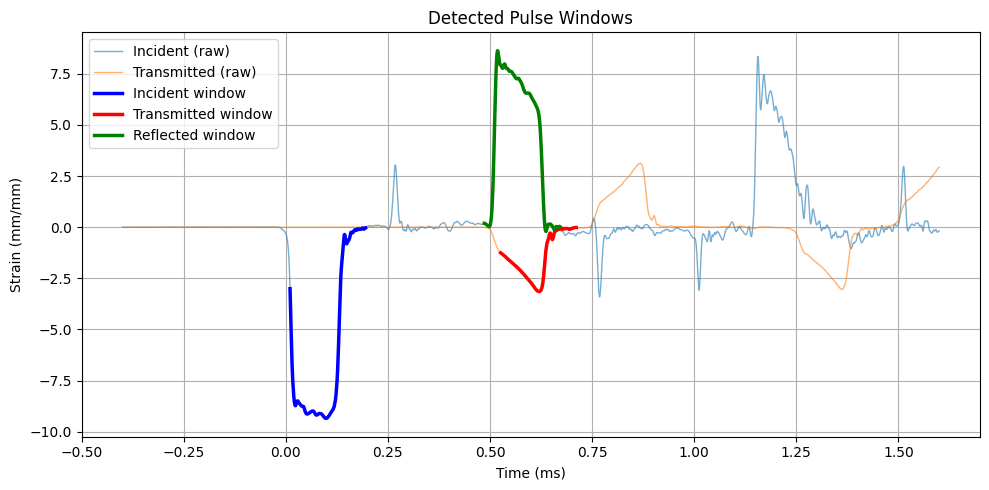

Window lengths:
  Incident: 14800 samples
  Transmitted: 14800 samples
  Reflected: 14800 samples


In [8]:
# Visualize detected windows
i0, i1 = incident_window
t0, t1 = transmitted_window
r0, r1 = reflected_window

fig, ax = plt.subplots(figsize=(10, 5))

# Full raw traces
ax.plot(raw_df["time"], raw_df["incident"], lw=1, alpha=0.6, label="Incident (raw)")
ax.plot(raw_df["time"], raw_df["transmitted"], lw=1, alpha=0.6, label="Transmitted (raw)")

# Highlight detected windows
ax.plot(raw_df["time"].iloc[i0:i1], raw_df["incident"].iloc[i0:i1], 
        lw=2.5, label="Incident window", c="blue")
ax.plot(raw_df["time"].iloc[t0:t1], raw_df["transmitted"].iloc[t0:t1], 
        lw=2.5, label="Transmitted window", c="red")
ax.plot(raw_df["time"].iloc[r0:r1], raw_df["incident"].iloc[r0:r1], 
        lw=2.5, label="Reflected window", c="green")

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Strain (mm/mm)")
ax.set_title("Detected Pulse Windows")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

print(f"Window lengths:")
print(f"  Incident: {i1-i0} samples")
print(f"  Transmitted: {t1-t0} samples")
print(f"  Reflected: {r1-r0} samples")

## Center and Segment Pulses
Extract, expand to N points, and center each pulse on its energy median.

[segment_and_center] shift = +2437 points
[segment_and_center] shift = +1616 points
[segment_and_center] shift = +1375 points


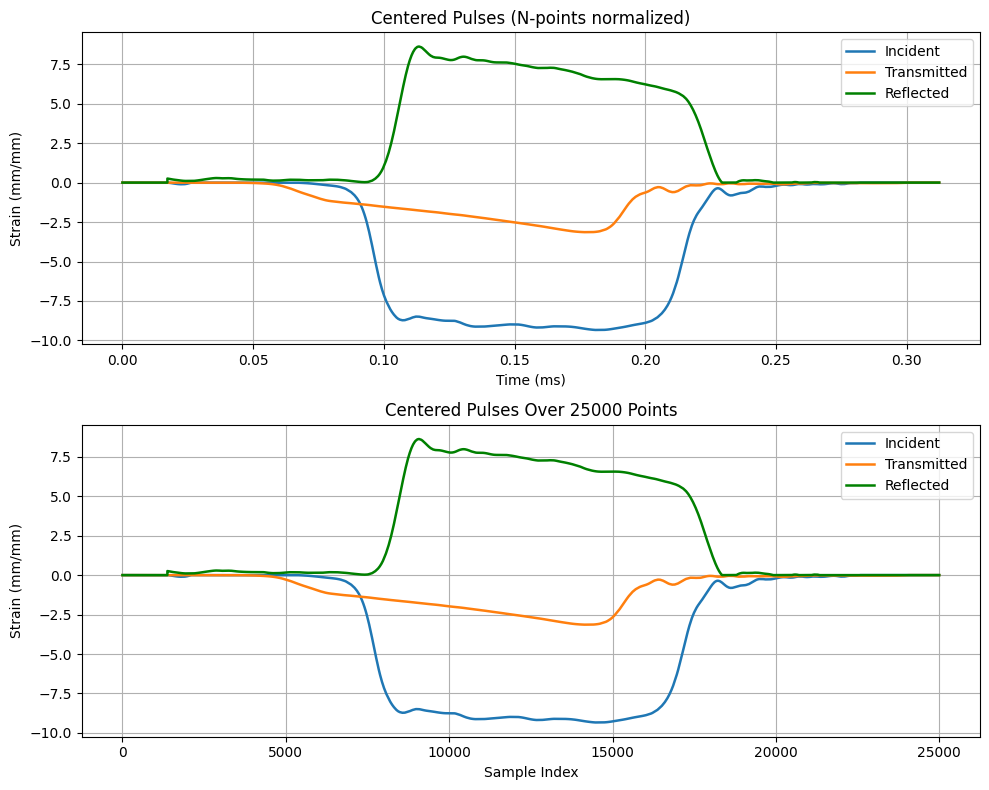


Segment shapes:
  Incident: (25000,)
  Transmitted: (25000,)
  Reflected: (25000,)


In [9]:
# Define number of points for centered segments
n_pts = 25000

# Segment and center incident pulse
inc_seg = detector.segment_and_center(
    raw_df["incident"].values,
    incident_window,
    n_points=n_pts,
    polarity="compressive",
    thresh_ratio=0.0,  # Set to 0 to keep all data (no noise suppression)
    debug=True
)

# Segment and center transmitted pulse
trs_seg = transmitted_detector.segment_and_center(
    raw_df["transmitted"].values,
    transmitted_window,
    n_points=n_pts,
    polarity="compressive",
    thresh_ratio=0.0,
    debug=True
)

# Segment and center reflected pulse
ref_seg = reflected_detector.segment_and_center(
    raw_df["incident"].values,  # Reflected is in incident channel
    reflected_window,
    n_points=n_pts,
    polarity="tensile",
    thresh_ratio=0.0,
    debug=True
)

# Visualize centered pulses
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Time axis for centered pulses
time_seg = np.arange(n_pts) * dt

# Plot 1: Centered pulses vs time
ax1.plot(time_seg, inc_seg, label="Incident", lw=1.8)
ax1.plot(time_seg, trs_seg, label="Transmitted", lw=1.8)
ax1.plot(time_seg, ref_seg, label="Reflected", lw=1.8, c="green")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Strain (mm/mm)")
ax1.set_title("Centered Pulses (N-points normalized)")
ax1.legend()
ax1.grid()

# Plot 2: Centered pulses vs sample index
ax2.plot(inc_seg, label="Incident", lw=1.8)
ax2.plot(trs_seg, label="Transmitted", lw=1.8)
ax2.plot(ref_seg, label="Reflected", lw=1.8, c="green")
ax2.set_xlabel("Sample Index")
ax2.set_ylabel("Strain (mm/mm)")
ax2.set_title(f"Centered Pulses Over {n_pts} Points")
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

print(f"\nSegment shapes:")
print(f"  Incident: {inc_seg.shape}")
print(f"  Transmitted: {trs_seg.shape}")
print(f"  Reflected: {ref_seg.shape}")

## Align Pulse Fronts
Shift all pulses so their rise fronts correlate to the post-processing operations. Removes time and spatial shifts from sensor distances.

In [10]:
# Define experimental parameters
# Bar properties (for steel bars, typical values)
bar_wave_speed = 5000.0      # mm/ms (or m/s depending on your units)
bar_cross_section = 71.26    # mm² (adjust to your bar)
bar_elastic_modulus = 200.0  # GPa (steel)
bar_density = 7850           # kg/m³

# Specimen properties (these would come from your specimen metadata)
specimen_length = 6.5        # mm (adjust to your specimen)
specimen_cross_section = 32.0  # mm² (adjust to your specimen)

# Optimization weights for fitness function
# These control the relative importance of each equilibrium criterion
opt_weights = {
    'corr': 0.3,   # Pulse correlation
    'u': 0.3,      # Bar displacement equilibrium
    'sr': 0.3,     # Strain rate equilibrium
    'e': 0.1       # Strain equilibrium
}

print(f"Experimental setup:")
print(f"  Bar wave speed: {bar_wave_speed} mm/ms")
print(f"  Specimen length: {specimen_length} mm")
print(f"  Specimen cross-section: {specimen_cross_section} mm²")
print(f"\nOptimization weights: {opt_weights}")

Experimental setup:
  Bar wave speed: 5000.0 mm/ms
  Specimen length: 6.5 mm
  Specimen cross-section: 32.0 mm²

Optimization weights: {'corr': 0.3, 'u': 0.3, 'sr': 0.3, 'e': 0.1}


In [11]:
# Create PulseAligner instance
aligner = PulseAligner(
    bar_wave_speed=bar_wave_speed,
    specimen_length=specimen_length,
    k_linear=0.35,  # Use 35% of steepest slope to define linear region
    weights=opt_weights
)

# Define search bounds for optimization
# These constrain where the algorithm looks for optimal shifts
# Adjust based on your experimental setup and expected pulse timing
search_bounds_t = (1300, 1500)    # Transmitted shift bounds (samples)
search_bounds_r = (-600, -100)  # Reflected shift bounds (samples)

print(f"PulseAligner initialized:")
print(f"  k_linear: {aligner.k_linear}")
print(f"  Search bounds transmitted: {search_bounds_t}")
print(f"  Search bounds reflected: {search_bounds_r}")

# Run alignment optimization
print(f"\nRunning alignment optimization...")
inc_aligned, trs_aligned, ref_aligned, shift_t, shift_r = aligner.align(
    incident=inc_seg,
    transmitted=trs_seg,
    reflected=ref_seg,
    time_vector=time_seg,
    search_bounds_t=search_bounds_t,
    search_bounds_r=search_bounds_r,
    debug=True  # Set to False to suppress optimization output
)

print(f"\n{'='*60}")
print(f"Alignment complete!")
print(f"  Transmitted shift: {shift_t:+d} samples")
print(f"  Reflected shift: {shift_r:+d} samples")
print(f"{'='*60}")

PulseAligner initialized:
  k_linear: 0.35
  Search bounds transmitted: (1300, 1500)
  Search bounds reflected: (-600, -100)

Running alignment optimization...
[PulseAligner] Linear region: [7233, 8193] (960 points)
[PulseAligner] Search bounds: T=(1300, 1500), R=(-600, -100)
differential_evolution step 1: f(x)= -0.2990778400297219
differential_evolution step 2: f(x)= -0.2991171018045462
differential_evolution step 3: f(x)= -0.2991171018045462
differential_evolution step 4: f(x)= -0.2991171018045462
differential_evolution step 5: f(x)= -0.2991286558497645
differential_evolution step 6: f(x)= -0.2991286558497645
differential_evolution step 7: f(x)= -0.29915565646132614
differential_evolution step 8: f(x)= -0.2991605461952978
differential_evolution step 9: f(x)= -0.2991605461952978
differential_evolution step 10: f(x)= -0.2991605461952978
differential_evolution step 11: f(x)= -0.2991605461952978
differential_evolution step 12: f(x)= -0.2991605461952978
differential_evolution step 13: f(x

In [12]:
# Build time axis centered on incident pulse rise
# Find the rise front (8% threshold of max amplitude)
front_thresh = 0.08
inc_abs = np.abs(inc_aligned)
front_idx = np.argmax(inc_abs > front_thresh * inc_abs.max())

# Create time axis with t=0 at the rise front
time_aligned = (np.arange(n_pts) - front_idx) * dt

print(f"Time axis centered on incident rise:")
print(f"  Rise front index: {front_idx}")
print(f"  Time range: [{time_aligned[0]:.3f}, {time_aligned[-1]:.3f}] ms")
print(f"  Zero crossing at sample {front_idx}")

Time axis centered on incident rise:
  Rise front index: 7078
  Time range: [-0.088, 0.224] ms
  Zero crossing at sample 7078


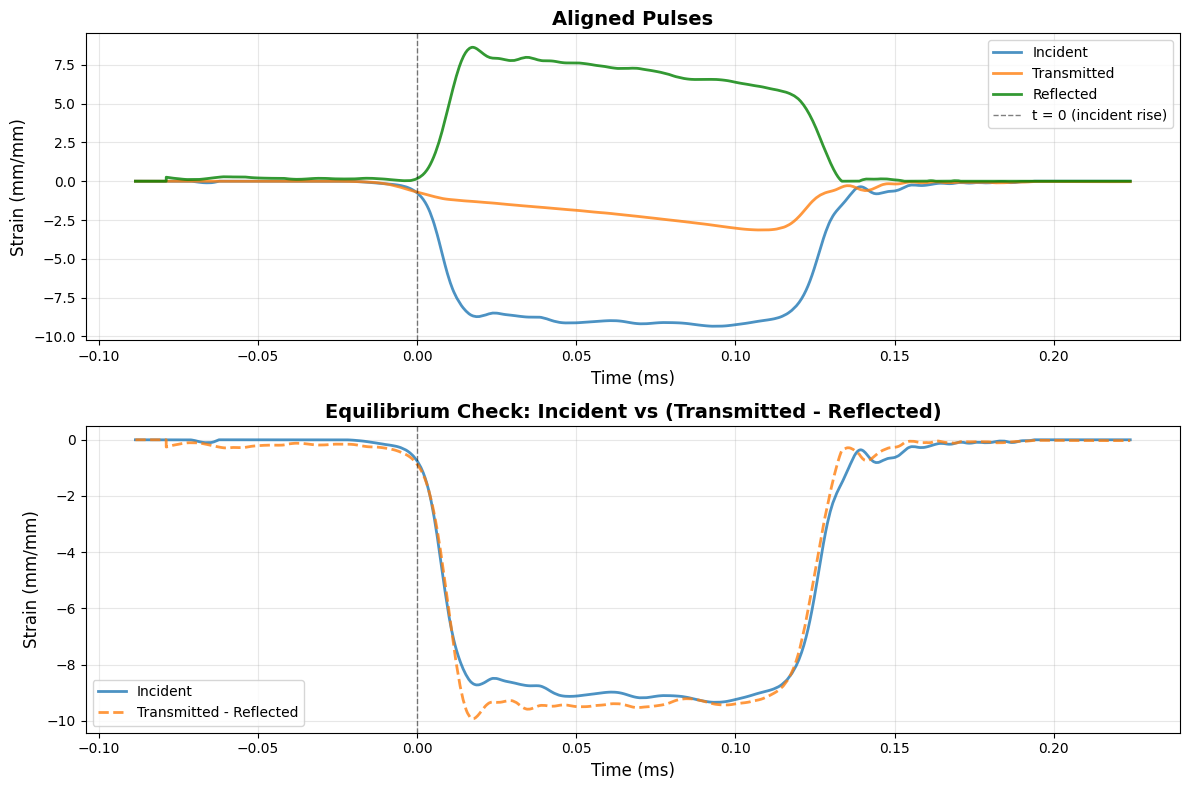


Equilibrium correlation:
  Pearson r = 0.9968 (p-value: 0.00e+00)


In [13]:
# Visualize aligned pulses
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Aligned pulses
ax1.plot(time_aligned, inc_aligned, lw=2.0, label="Incident", alpha=0.8)
ax1.plot(time_aligned, trs_aligned, lw=2.0, label="Transmitted", alpha=0.8)
ax1.plot(time_aligned, ref_aligned, lw=2.0, label="Reflected", c="green", alpha=0.8)
ax1.axvline(0, ls="--", c="k", lw=1, alpha=0.5, label="t = 0 (incident rise)")
ax1.set_xlabel("Time (ms)", fontsize=12)
ax1.set_ylabel("Strain (mm/mm)", fontsize=12)
ax1.set_title("Aligned Pulses", fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(alpha=0.3)

# Plot 2: Check equilibrium (incident vs transmitted - reflected)
equilibrium_check = trs_aligned - ref_aligned
ax2.plot(time_aligned, inc_aligned, lw=2.0, label="Incident", alpha=0.8)
ax2.plot(time_aligned, equilibrium_check, lw=2.0, label="Transmitted - Reflected",
         alpha=0.8, ls='--')
ax2.axvline(0, ls="--", c="k", lw=1, alpha=0.5)
ax2.set_xlabel("Time (ms)", fontsize=12)
ax2.set_ylabel("Strain (mm/mm)", fontsize=12)
ax2.set_title("Equilibrium Check: Incident vs (Transmitted - Reflected)",
              fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display correlation coefficient
from scipy.stats import pearsonr
# Use only the region where both signals are non-zero
mask = (np.abs(inc_aligned) > 1e-6) & (np.abs(equilibrium_check) > 1e-6)
if mask.sum() > 0:
    corr, pval = pearsonr(inc_aligned[mask], equilibrium_check[mask])
    print(f"\nEquilibrium correlation:")
    print(f"  Pearson r = {corr:.4f} (p-value: {pval:.2e})")

## Calculate Stress-Strain Curves
Use the StressStrainCalculator class to compute engineering stress, strain, and strain rate from the aligned pulses.

In [22]:
# Define experimental parameters for stress-strain calculation
# Bar properties
bar_diameter = 19.0           # mm                                                  # DYN: Bar Properties should be extracted from dyn:Material
bar_wave_speed = 5000.0       # mm/ms (steel)
bar_elastic_modulus = 200     # GPa (steel)

# Specimen properties (these should come from your specimen metadata)
specimen_diameter = 12.7      # mm                                                 # DYN: Specimen dimensions should be extracted from dyn:Specimen
specimen_length = 6.5         # mm

# Strain scale factor for converting gauge output to dimensionless strain
# Default is 1e4 (assumes gauge output where 10000 = 1.0 strain)
strain_scale_factor = 1e3

print(f"Experimental setup:")
print(f"  Bar diameter: {bar_diameter} mm")
print(f"  Bar wave speed: {bar_wave_speed} mm/ms")
print(f"  Bar Young's modulus: {bar_elastic_modulus} GPa")
print(f"  Specimen diameter: {specimen_diameter} mm")
print(f"  Specimen length: {specimen_length} mm")
print(f"  Strain scale factor: {strain_scale_factor}")

# Create StressStrainCalculator instance with strain scale factor
calculator = StressStrainCalculator(
    bar_diameter=bar_diameter,
    bar_wave_speed=bar_wave_speed,
    bar_elastic_modulus=bar_elastic_modulus,
    specimen_diameter=specimen_diameter,
    specimen_length=specimen_length,
    strain_scale_factor=strain_scale_factor
)

print(f"\nStressStrainCalculator initialized:")
print(f"  Bar area: {calculator.bar_area:.2f} mm²")
print(f"  Specimen area: {calculator.specimen_area:.2f} mm²")
print(f"  Area ratio: {calculator.area_ratio:.3f}")
print(f"  Strain scale factor: {calculator.strain_scale_factor}")

Experimental setup:
  Bar diameter: 19.0 mm
  Bar wave speed: 5000.0 mm/ms
  Bar Young's modulus: 200 GPa
  Specimen diameter: 12.7 mm
  Specimen length: 6.5 mm
  Strain scale factor: 1000.0

StressStrainCalculator initialized:
  Bar area: 283.53 mm²
  Specimen area: 126.68 mm²
  Area ratio: 2.238
  Strain scale factor: 1000.0


In [23]:
# Calculate stress-strain curves using all three methods
all_results = calculator.calculate_all_methods(
    incident=inc_aligned,
    transmitted=trs_aligned,
    reflected=ref_aligned,
    time_vector=time_aligned
)

# Extract results for each method
results_1w = all_results['1-wave']
results_2w = all_results['2-wave']
results_3w = all_results['3-wave']

print("Stress-strain calculation complete!")
print(f"\nData shapes (all methods):")
print(f"  Time: {results_1w['time'].shape}")
print(f"  Stress: {results_1w['stress'].shape}")
print(f"  Strain: {results_1w['strain'].shape}")
print(f"  Strain rate: {results_1w['strain_rate'].shape}")

print(f"\nPeak values (1-wave method):")
print(f"  Max stress: {results_1w['stress'].max():.2f} MPa")
print(f"  Max strain: {results_1w['strain'].max():.4f}")
print(f"  Max strain rate: {results_1w['strain_rate'].max():.2f} 1/s")

Stress-strain calculation complete!

Data shapes (all methods):
  Time: (25000,)
  Stress: (25000,)
  Strain: (25000,)
  Strain rate: (25000,)

Peak values (1-wave method):
  Max stress: 1407.52 MPa
  Max strain: 1.3069
  Max strain rate: 13271.60 1/s


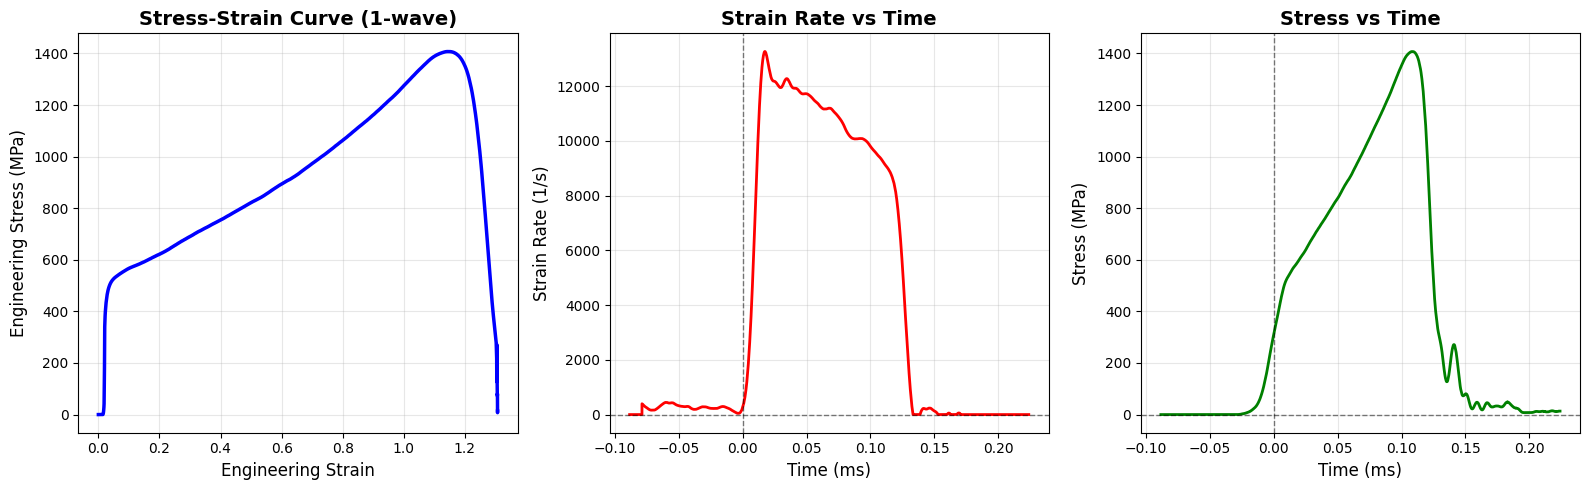

In [24]:
# Visualize stress-strain curve
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Stress-Strain curve (1-wave method)
ax1.plot(results_1w['strain'], results_1w['stress'], lw=2.5, color='blue')
ax1.set_xlabel('Engineering Strain', fontsize=12)
ax1.set_ylabel('Engineering Stress (MPa)', fontsize=12)
ax1.set_title('Stress-Strain Curve (1-wave)', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# Plot 2: Strain rate vs time
ax2.plot(results_1w['time'], results_1w['strain_rate'], lw=2.0, color='red')
ax2.axhline(0, ls='--', c='k', lw=1, alpha=0.5)
ax2.axvline(0, ls='--', c='k', lw=1, alpha=0.5)
ax2.set_xlabel('Time (ms)', fontsize=12)
ax2.set_ylabel('Strain Rate (1/s)', fontsize=12)
ax2.set_title('Strain Rate vs Time', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

# Plot 3: Stress vs time
ax3.plot(results_1w['time'], results_1w['stress'], lw=2.0, color='green')
ax3.axhline(0, ls='--', c='k', lw=1, alpha=0.5)
ax3.axvline(0, ls='--', c='k', lw=1, alpha=0.5)
ax3.set_xlabel('Time (ms)', fontsize=12)
ax3.set_ylabel('Stress (MPa)', fontsize=12)
ax3.set_title('Stress vs Time', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()

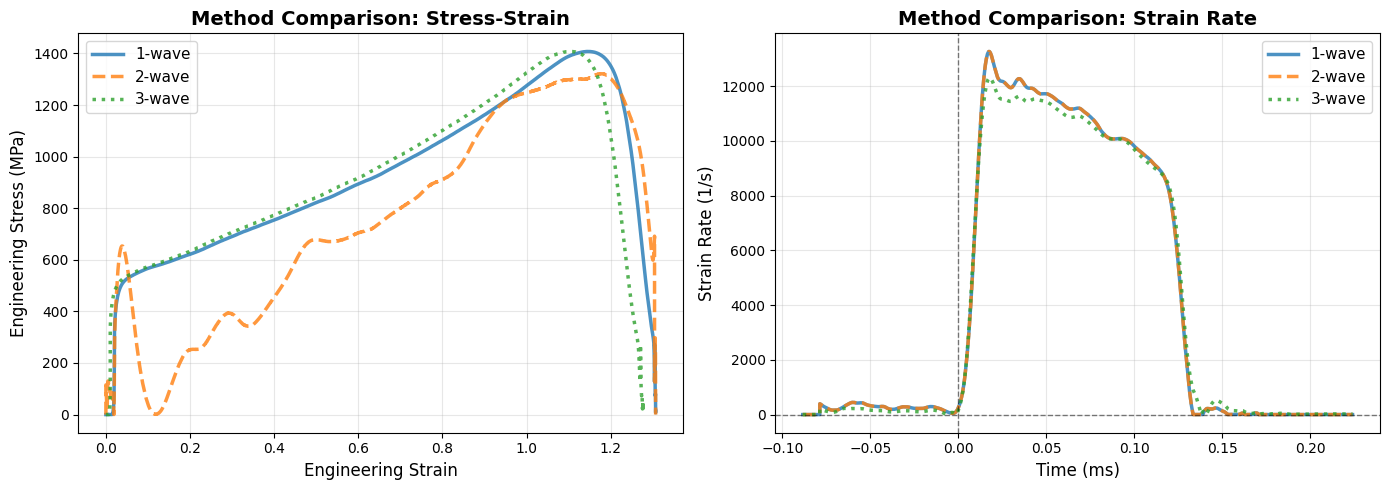


Equilibrium validation (1-wave vs 2-wave stress):
  Mean absolute error: 112.85 MPa
  Max absolute error: 575.74 MPa
  Relative error: 8.02%


In [25]:
# Compare all three analysis methods
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Stress-strain curves comparison
ax1.plot(results_1w['strain'], results_1w['stress'], lw=2.5, label='1-wave', alpha=0.8)
ax1.plot(results_2w['strain'], results_2w['stress'], lw=2.5, label='2-wave', alpha=0.8, ls='--')
ax1.plot(results_3w['strain'], results_3w['stress'], lw=2.5, label='3-wave', alpha=0.8, ls=':')
ax1.set_xlabel('Engineering Strain', fontsize=12)
ax1.set_ylabel('Engineering Stress (MPa)', fontsize=12)
ax1.set_title('Method Comparison: Stress-Strain', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Plot 2: Strain rate comparison
ax2.plot(results_1w['time'], results_1w['strain_rate'], lw=2.5, label='1-wave', alpha=0.8)
ax2.plot(results_2w['time'], results_2w['strain_rate'], lw=2.5, label='2-wave', alpha=0.8, ls='--')
ax2.plot(results_3w['time'], results_3w['strain_rate'], lw=2.5, label='3-wave', alpha=0.8, ls=':')
ax2.axhline(0, ls='--', c='k', lw=1, alpha=0.5)
ax2.axvline(0, ls='--', c='k', lw=1, alpha=0.5)
ax2.set_xlabel('Time (ms)', fontsize=12)
ax2.set_ylabel('Strain Rate (1/s)', fontsize=12)
ax2.set_title('Method Comparison: Strain Rate', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate equilibrium error (difference between 1-wave and 2-wave stress)
stress_error = np.abs(results_1w['stress'] - results_2w['stress'])
mean_error = np.mean(stress_error)
max_error = np.max(stress_error)

print(f"\nEquilibrium validation (1-wave vs 2-wave stress):")
print(f"  Mean absolute error: {mean_error:.2f} MPa")
print(f"  Max absolute error: {max_error:.2f} MPa")
print(f"  Relative error: {100*mean_error/results_1w['stress'].max():.2f}%")

## Apply Tukey Window for ML Applications
Use the TukeyWindow class to taper signals before machine learning feature extraction. This reduces edge effects and prepares clean signals for ML pipelines.

In [18]:
# Create TukeyWindow instances with different alpha values
tukey_50 = TukeyWindow(alpha=0.5)  # 50% tapering (recommended)
tukey_30 = TukeyWindow(alpha=0.3)  # 30% tapering (less aggressive)
tukey_70 = TukeyWindow(alpha=0.7)  # 70% tapering (more aggressive)

# Generate windows for the pulse length
window_50 = tukey_50.generate(len(inc_aligned))
window_30 = tukey_30.generate(len(inc_aligned))
window_70 = tukey_70.generate(len(inc_aligned))

print(f"TukeyWindow instances created:")
print(f"  Alpha = 0.3: {tukey_30}")
print(f"  Alpha = 0.5: {tukey_50}")
print(f"  Alpha = 0.7: {tukey_70}")
print(f"\nWindow length: {len(window_50)} samples")

TukeyWindow instances created:
  Alpha = 0.3: TukeyWindow(alpha=0.3)
  Alpha = 0.5: TukeyWindow(alpha=0.5)
  Alpha = 0.7: TukeyWindow(alpha=0.7)

Window length: 25000 samples


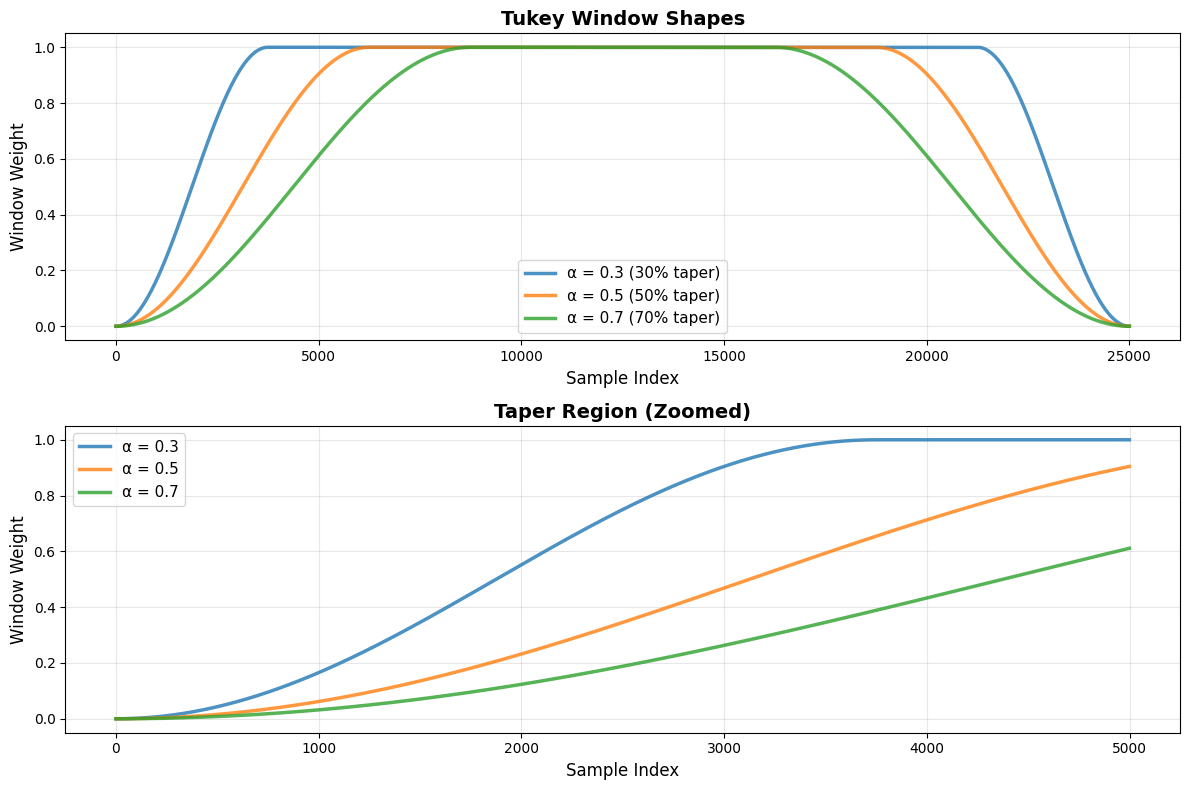

In [19]:
# Visualize Tukey windows with different alpha values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Window shapes
ax1.plot(window_30, lw=2.5, label='α = 0.3 (30% taper)', alpha=0.8)
ax1.plot(window_50, lw=2.5, label='α = 0.5 (50% taper)', alpha=0.8)
ax1.plot(window_70, lw=2.5, label='α = 0.7 (70% taper)', alpha=0.8)
ax1.set_xlabel('Sample Index', fontsize=12)
ax1.set_ylabel('Window Weight', fontsize=12)
ax1.set_title('Tukey Window Shapes', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)
ax1.set_ylim(-0.05, 1.05)

# Plot 2: Zoomed view of taper region (first 20% of signal)
zoom_len = int(0.2 * len(window_50))
ax2.plot(window_30[:zoom_len], lw=2.5, label='α = 0.3', alpha=0.8)
ax2.plot(window_50[:zoom_len], lw=2.5, label='α = 0.5', alpha=0.8)
ax2.plot(window_70[:zoom_len], lw=2.5, label='α = 0.7', alpha=0.8)
ax2.set_xlabel('Sample Index', fontsize=12)
ax2.set_ylabel('Window Weight', fontsize=12)
ax2.set_title('Taper Region (Zoomed)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)
ax2.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

In [20]:
# Apply Tukey window to aligned pulses (using alpha=0.5 for ML preprocessing)
inc_tapered = tukey_50.apply(inc_aligned)
trs_tapered = tukey_50.apply(trs_aligned)
ref_tapered = tukey_50.apply(ref_aligned)

print(f"Tukey window applied (α=0.5):")
print(f"  Incident: {inc_aligned.shape} → {inc_tapered.shape}")
print(f"  Transmitted: {trs_aligned.shape} → {trs_tapered.shape}")
print(f"  Reflected: {ref_aligned.shape} → {ref_tapered.shape}")

# Compare energy before and after tapering
energy_before = np.sum(inc_aligned**2)
energy_after = np.sum(inc_tapered**2)
energy_loss = 100 * (1 - energy_after/energy_before)

print(f"\nEnergy analysis (incident pulse):")
print(f"  Energy before tapering: {energy_before:.2e}")
print(f"  Energy after tapering: {energy_after:.2e}")
print(f"  Energy loss: {energy_loss:.2f}%")

Tukey window applied (α=0.5):
  Incident: (25000,) → (25000,)
  Transmitted: (25000,) → (25000,)
  Reflected: (25000,) → (25000,)

Energy analysis (incident pulse):
  Energy before tapering: 7.34e+05
  Energy after tapering: 7.34e+05
  Energy loss: 0.00%


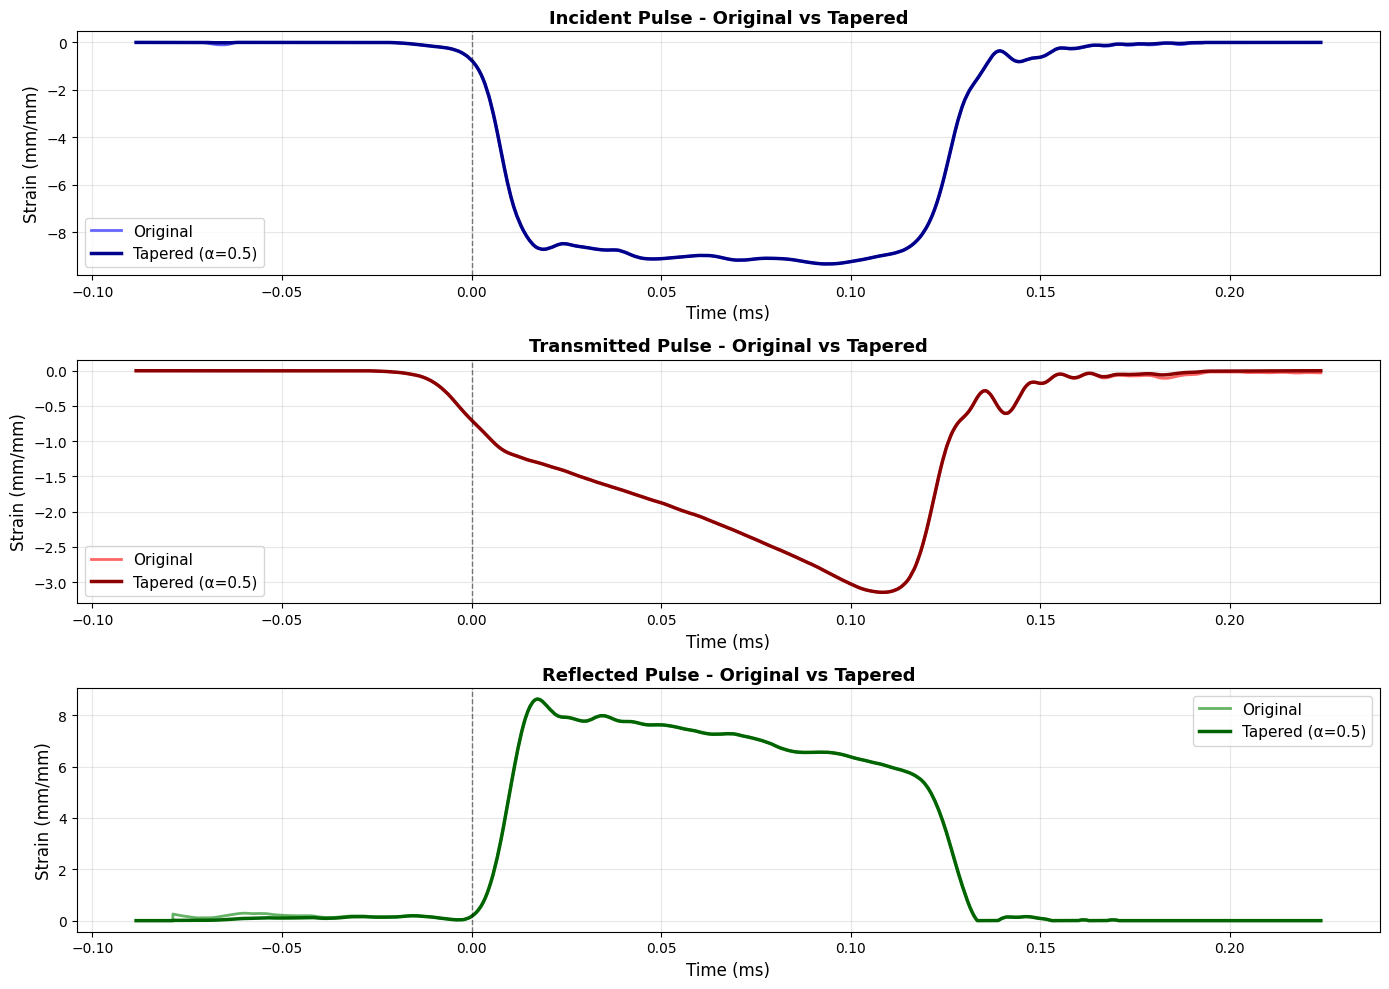

In [21]:
# Visualize effect of Tukey window on pulses
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Incident pulse
axes[0].plot(time_aligned, inc_aligned, lw=2.0, alpha=0.6, label='Original', color='blue')
axes[0].plot(time_aligned, inc_tapered, lw=2.5, label='Tapered (α=0.5)', color='darkblue')
axes[0].axvline(0, ls='--', c='k', lw=1, alpha=0.5)
axes[0].set_xlabel('Time (ms)', fontsize=12)
axes[0].set_ylabel('Strain (mm/mm)', fontsize=12)
axes[0].set_title('Incident Pulse - Original vs Tapered', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Transmitted pulse
axes[1].plot(time_aligned, trs_aligned, lw=2.0, alpha=0.6, label='Original', color='red')
axes[1].plot(time_aligned, trs_tapered, lw=2.5, label='Tapered (α=0.5)', color='darkred')
axes[1].axvline(0, ls='--', c='k', lw=1, alpha=0.5)
axes[1].set_xlabel('Time (ms)', fontsize=12)
axes[1].set_ylabel('Strain (mm/mm)', fontsize=12)
axes[1].set_title('Transmitted Pulse - Original vs Tapered', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

# Reflected pulse
axes[2].plot(time_aligned, ref_aligned, lw=2.0, alpha=0.6, label='Original', color='green')
axes[2].plot(time_aligned, ref_tapered, lw=2.5, label='Tapered (α=0.5)', color='darkgreen')
axes[2].axvline(0, ls='--', c='k', lw=1, alpha=0.5)
axes[2].set_xlabel('Time (ms)', fontsize=12)
axes[2].set_ylabel('Strain (mm/mm)', fontsize=12)
axes[2].set_title('Reflected Pulse - Original vs Tapered', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=11)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()